# Proyecto ML: Modelo predictivo de precios de coche.

## 1. Introducción.

En este cuaderno buscaremos elaborar un modelo predictivo utilizando Machine Learning para saber una estimación del precio de un determinado vehículo de segunda mano y poder optimizar la compraventa de coches.

Por esto, el objetivo es tener una plataforma web donde poder saber el precio de un determinado vehículo de segunda mano, en base al precio de otros coches registrados en nuestra base de datos. Para ello, se utilizan los registros guardados en la tabla TX_VEHICULOS_SEG_MANO de nuestra BBDD de sqlite, con cerca de 35.000 registros de vehículos de 10 marcas diferentes importadas desde un Dataset de Kaggle hecho a partir de WebScraping, a los que hemos añadido X vehículos scrapeados mediante el script guardado en la ruta ```"dags/webscraping_script.py"``` de la página de [coches.net](coches.net).

Los registros obtenidos mediante ambos orígenes de datos han sido posibles de combinar mediante las transformaciones realizadas en el cuaderno ```"notebooks/kaggle_dataset_cleaning.ipynb"```, aunque antes de entrenar el modelo predictivo será necesario realizar algunas transformaciones adicionales, así como seleccionar las features del modelo.

En este proyecto, se utilizarán modelos de Machine Learning para calcular el precio de un coche a partir de características como la marca, modelo, tipo de combustible, año, etc. Se trata, por tanto, de un problema de regresión. Se utilizará como métrica de optimización el Mean Squared Error (MSE), aunque también se analizarán otras métricas como el Mean Average Error (MAE).

## 2. Obtención y procesado de datos.

Importamos los datos desde nuestra base de datos:

In [41]:
# Importamos las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


sns.set_style("darkgrid")


colors = ["#d5001c", "#f59908", "#ffcb01", "#969696"]

In [42]:
import sqlite3
import pandas as pd

con = sqlite3.connect("../include/db_vehiculos.db")

query = """
SELECT *
FROM TX_VEHICULOS_SEG_MANO
where
    --origen_anuncio = 'WebScraping'
    --origen_anuncio = 'dataset kaggle'
    --and marca not in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT')
    marca in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT', 'HYUNDAI', 'KIA', 'NISSAN', 'TOYOTA')
order by
    fecha_carga desc
;
"""

df = pd.read_sql_query(query, con)

df.head()

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60611029,AUDI,a3,25290.0,Híbrido,2023.0,46273,110.0,5.0,5.0,...,Berlina,999.0,negro,Ciudad Real,ECO (azul/verde),WebScraping,2025-05-20,202505,2025-06-07 06:51:00,https://www.coches.net/audi-a3-sportback-30-tf...
1,60652943,HYUNDAI,i30,14850.0,Híbrido,2022.0,103209,120.0,5.0,5.0,...,Familiar,998.0,None,A Coruña,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:24:18,https://www.coches.net/hyundai-i30-10-tgdi-48v...
2,60716264,TOYOTA,c-hr,20100.0,Híbrido,2020.0,110745,122.0,5.0,5.0,...,Berlina,1798.0,blanco,Madrid,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:22:36,https://www.coches.net/toyota-c-hr-18-125h-act...
3,60206285,NISSAN,juke,17990.0,Gasolina,2022.0,63000,114.0,5.0,5.0,...,SUV,999.0,None,Las Palmas,None,WebScraping,2025-06-03,202506,2025-06-03 13:21:36,https://www.coches.net/nissan-juke-digt-84-kw-...
4,60716125,NISSAN,qashqai,24390.0,Híbrido,2022.0,62765,140.0,5.0,5.0,...,SUV,1332.0,negro,Huelva,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:20:26,https://www.coches.net/nissan-qashqai-digt-103...


Podemos ver el número de registros para cada origen de datos:

In [43]:
df['origen_anuncio'].value_counts()

origen_anuncio
dataset kaggle    40503
WebScraping        7550
Name: count, dtype: int64

Vemos que la gran mayoría de registros provienen del dataset de kaggle.

Vamos a ver qué columnas contiene el DataFrame:

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48053 entries, 0 to 48052
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        48053 non-null  int64  
 1   marca                48053 non-null  object 
 2   modelo               48053 non-null  object 
 3   precio               48053 non-null  float64
 4   combustible          47833 non-null  object 
 5   anyo_vehiculo        48051 non-null  float64
 6   kilometraje          48053 non-null  int64  
 7   potencia             40572 non-null  float64
 8   num_puertas          47938 non-null  float64
 9   num_plazas           7430 non-null   float64
 10  tipo_cambio          47962 non-null  object 
 11  tipo_vehiculo        7550 non-null   object 
 12  cilindrada_motor     7389 non-null   float64
 13  color                46680 non-null  object 
 14  provincia            48048 non-null  object 
 15  etiqueta_eco         5310 non-null  

Vemos que el DataFrame se compone de 21 columnas, de las cuales, muchas de ellas son de tipo string. Además, contienen valores nulos, por lo que, a continuación, haremos un procesado de estas columnas.

La columna target u objetivo a predecir es la columna llamada ```"precio"```.

Lo primero que haremos es eliminar las columnas ```['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco']```, ya que solo tienen valores no nulos para los registros obtenidos mediante WebScraping.

In [45]:
df = df.drop(columns=['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48053 entries, 0 to 48052
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        48053 non-null  int64  
 1   marca                48053 non-null  object 
 2   modelo               48053 non-null  object 
 3   precio               48053 non-null  float64
 4   combustible          47833 non-null  object 
 5   anyo_vehiculo        48051 non-null  float64
 6   kilometraje          48053 non-null  int64  
 7   potencia             40572 non-null  float64
 8   num_puertas          47938 non-null  float64
 9   tipo_cambio          47962 non-null  object 
 10  color                46680 non-null  object 
 11  provincia            48048 non-null  object 
 12  origen_anuncio       48053 non-null  object 
 13  fecha_publicacion    48053 non-null  object 
 14  anyomes_publicacion  48053 non-null  int64  
 15  fecha_carga          48053 non-null 

Vamos a eliminar también las columnas: ```['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url']```, ya que tampoco aportan información para el modelo.

De momento dejamos la columna ```'origen_anuncio'``` por si hay que distinguir en alguna transformación entre los datos de ambos orígenes.

In [46]:
df = df.drop(columns=['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48053 entries, 0 to 48052
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           48053 non-null  object 
 1   modelo          48053 non-null  object 
 2   precio          48053 non-null  float64
 3   combustible     47833 non-null  object 
 4   anyo_vehiculo   48051 non-null  float64
 5   kilometraje     48053 non-null  int64  
 6   potencia        40572 non-null  float64
 7   num_puertas     47938 non-null  float64
 8   tipo_cambio     47962 non-null  object 
 9   color           46680 non-null  object 
 10  origen_anuncio  48053 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 4.0+ MB


### Variable objetivo: precio.

Vamos a ver la distibución de datos de la columna target (```"precio"```):

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x600 with 0 Axes>

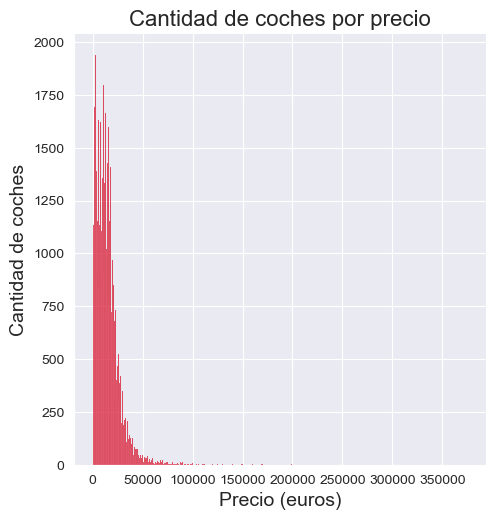

In [47]:
plt.figure(figsize=(8, 6))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio", fontsize=16)

plt.xlabel("Precio (euros)", fontsize=14)
plt.ylabel("Cantidad de coches", fontsize=14)

plt.show()

Vemos que existen muchos coches con un precio más bajo, y que, para precios más elevados, se reduce el número. Para corregir esto, y aumentar la eficacia del modelo predictivo, vamos a plantear dos medidas:

1. Realizar un boxplot para detectar outliers y poder eliminar estos registros.

2. Aplicar una transformación a la columna ```"precio"```, de modo que los datos tiendan a una distribución normal. Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

Comenzamos realizando el Boxplot:

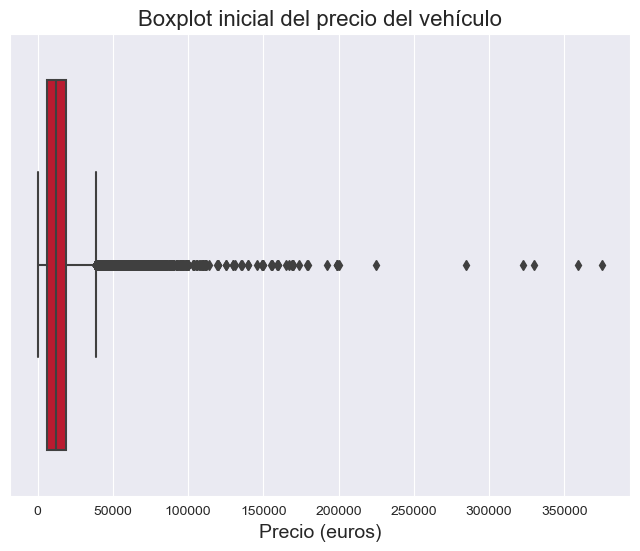

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Boxplot de la variable "precio"
sns.boxplot(x=df["precio"], color=colors[0])

# Títulos y etiquetas
plt.title("Boxplot inicial del precio del vehículo", fontsize=16)
plt.xlabel("Precio (euros)", fontsize=14)

plt.show()


Vemos que la distribución del boxplot muestra que el 75 % de los registros se concentran por debajo de los 20.000 euros aproximadamente.

Vamos a ver las principales medidas estadísticas de la variable ```"precio"```:

In [49]:
df["precio"].describe()

count     48053.000000
mean      14414.972759
std       12638.703364
min         300.000000
25%        6000.000000
50%       12450.000000
75%       18990.000000
max      375000.000000
Name: precio, dtype: float64

In [50]:
# df = df.loc[df.loc[:, "precio"] < 101000, :]

Observamos que la variable tiene una media de 14.414 euros y una desviación estándar (sigma) de 12.638 euros. Sin embargo, el valor máximo es de 375.000 euros.

Ante esto, vamos a proponer dos opciones para eliminar outliers que puedan influir negativamente en el modelo o para los cuáles funcione muy mal.

1. Coger los valores dentro de los siguientes límites a partir del Rango intercuartílico (IQR), que marcarían los outliers tradicionales:

    - limite_inferior = Q1 - 1.5 * IQR
    - limite_superior = Q3 + 1.5 * IQR

Probamos esta opción:


Opción con cuartiles:

In [51]:
# Calculamos Q1, Q3 e IQR
Q1 = df["precio"].quantile(0.25)
Q3 = df["precio"].quantile(0.75)
IQR = Q3 - Q1

# Límites inferior y superior para considerar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Límite de precio inferior: {limite_inferior}")
print(f"Límite de precio superior: {limite_superior}")

df_iqr = df[(df["precio"] >= limite_inferior) & (df["precio"] <= limite_superior)]

print(f"Número de coches antes de eliminar outliers: {len(df)}")
print(f"Número de coches después de eliminar outliers: {len(df_iqr)}")


Límite de precio inferior: -13485.0
Límite de precio superior: 38475.0
Número de coches antes de eliminar outliers: 48053
Número de coches después de eliminar outliers: 46336


Si utilizamos esta opción seguro que el modelo funciona muy bien pero solo predeciríamos vehículos con precios hasta 38.475 euros, lo que dejaría fuera muchos modelos.

Por ello, vamos a descartar esta opción.

Probaremos una segunda opción que consiste en aplicar una transformación a la columna ```"precio"```, de modo que los datos tiendan a una distribución normal. Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

Vamos a comparar los resultados del test de normalidad de Shapiro-Wilk para 3 transformaciones que normalizan una variable: logarítmica, raíz cuadrada y Box-Cox. Se ha escogido un tamaño de muestra de 1.000 datos, ya que contamos con cerca de 48.000 registros.

In [52]:
# pip install --upgrade scipy

In [53]:
from scipy.stats import boxcox, shapiro
from scipy.special import inv_boxcox
import numpy as np
import pandas as pd

# Comparar diferentes transformaciones
precio_original = df["precio"]

# Logarítmica
precio_log = np.log(precio_original)

# Raíz cuadrada
precio_sqrt = np.sqrt(precio_original)

# Box-Cox
precio_boxcox, lambda_opt = boxcox(precio_original)

# Muestra aleatoria
np.random.seed(42) 
n_sample = 1000


indices = np.random.choice(len(precio_original), size=n_sample, replace=False)

# Aplicar a todas las transformaciones
sample_log = precio_log.iloc[indices]
sample_sqrt = precio_sqrt.iloc[indices]
sample_boxcox = precio_boxcox[indices] 

# Comparar estadísticos W y p del test de shapiro
w_log, p_log = shapiro(sample_log)
w_sqrt, p_sqrt = shapiro(sample_sqrt)
w_boxcox, p_boxcox = shapiro(sample_boxcox)

print(f"Transformación logarítmica:")
print(f"  W: {w_log:.4f}, p-valor: {p_log:.2e}")
print(f"\nTransformación raíz cuadrada:")
print(f"  W: {w_sqrt:.4f}, p-valor: {p_sqrt:.2e}")
print(f"\nTransformación Box-Cox (lambda={lambda_opt:.3f}):")
print(f"  W: {w_boxcox:.4f}, p-valor: {p_boxcox:.2e}")

# Comparar resultados de las transformaciones

transformaciones = {
    'Logarítmica': [w_log, p_log],
    'Raíz cuadrada': [w_sqrt, p_sqrt],
    'Box-Cox': [w_boxcox, p_boxcox]
}

# Encontrar la transformación con el mayor estadístico W
mejor_w = max(transformaciones, key=lambda t: transformaciones[t][0])
# Encontrar la transformación con el mayor p-valor
mejor_p = transformaciones[mejor_w][1]

# Imprimir la mejor transformación
print(f"\nMejor transformación: {mejor_w} (W = {transformaciones[mejor_w][0]:.4f}), (p-valor={mejor_p:.8f})")

# Interpretar el p-valor: si es mayor que 0.05, no se rechaza la hipótesis de normalidad
if mejor_p > 0.05:
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no siguen una distribución normal.")

Transformación logarítmica:
  W: 0.9384, p-valor: 6.27e-20

Transformación raíz cuadrada:
  W: 0.9782, p-valor: 4.15e-11

Transformación Box-Cox (lambda=0.281):
  W: 0.9862, p-valor: 4.25e-08

Mejor transformación: Box-Cox (W = 0.9862), (p-valor=0.00000004)
Se rechaza H₀: los datos no siguen una distribución normal.


Se obtiene que la mejor transformación es la Box-Cox. Según el resultado del p-valor obtenido, la distribución no es normal, pero el valor del estadístico W = 0,9862 es muy cercano a 1 (lo que sería una distribución perfectamente normal), por lo que la transformación acerca mucho la distribución a la normalidad, lo que mejora el rendimiento de los modelos predictivos de regresión.

Vamos a realizar la transformación de la columna y mostrar la distribución de precios una vez transformada. Después, nos quedaremos con los vehículos en un rango de valores del precio transformado de 3 desviaciones estándar a partir de la media, que coresponderá a un porcentaje muy elevado de los datos.

In [54]:
# Transformación BoxCox:

df["precio"], lambda_opt = boxcox(df["precio"])

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x600 with 0 Axes>

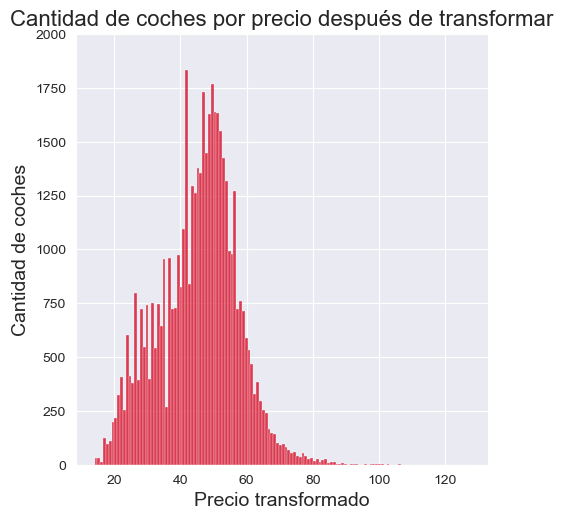

In [55]:
plt.figure(figsize=(8, 6))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio después de transformar", fontsize=16)

plt.xlabel("Precio transformado", fontsize=14)
plt.ylabel("Cantidad de coches", fontsize=14)

plt.yticks(range(0, 2250, 250))

plt.show()

In [56]:
lambda_opt

0.2805938921162534

In [57]:
mean_log = df["precio"].mean()
std_log = df["precio"].std()

# Límite superior a 3 sigmas en escala logarítmica:
upper_log_limit = mean_log + 3 * std_log

# Filtramos solo los valores dentro de las 2 sigmas:
df_filtrado = df[df["precio"] <= upper_log_limit]

# (Opcional) Si necesitamos volver a la escala original:
max_precio_filtrado = inv_boxcox(upper_log_limit, lambda_opt)

num_coches_eliminados = len(df) - len(df_filtrado)

print(f"Límite superior en escala Box-Cox: {upper_log_limit:.4f}")
print(f"Corresponde a un precio real de: {max_precio_filtrado:,.2f} €")

print(f"Número de coches antes de eliminar outliers: {len(df)}")
print(f"Número de coches después de eliminar outliers: {len(df_filtrado)}")
print(f"Número de coches eliminados: {num_coches_eliminados}")

Límite superior en escala Box-Cox: 80.9542
Corresponde a un precio real de: 79,509.65 €
Número de coches antes de eliminar outliers: 48053
Número de coches después de eliminar outliers: 47870
Número de coches eliminados: 183


In [58]:
# import numpy as np

# # Transformación logarítmica del precio:
# df["precio"] = np.log(df["precio"])

In [59]:
# plt.figure(figsize=(8, 6))

# sns.displot(df["precio"], color=colors[0])

# plt.title("Cantidad de coches por precio después de transformar", fontsize=16)

# plt.xlabel("Precio transformado", fontsize=14)
# plt.ylabel("Cantidad de coches", fontsize=14)

# plt.yticks(range(0, 2250, 250))

# plt.show()

In [60]:
# from scipy.stats import shapiro

# # Aplicar el test de Shapiro-Wilk a una muestra (máx. 5000 datos recomendado)
# sample = df["precio"].sample(n=1000, random_state=42)

# stat, p_value = shapiro(sample)

# print(f"Estadístico W: {stat:.4f}")
# print(f"Valor p: {p_value:.22f}")

# if p_value > 0.05:
#     print("No se rechaza H₀: los datos podrían ser normales.")
# else:
#     print("Se rechaza H₀: los datos no siguen una distribución normal.")


In [61]:
# mean_log = df["precio"].mean()
# std_log = df["precio"].std()

# # Límite superior a 2 sigmas en escala logarítmica:
# upper_log_limit = mean_log + 2 * std_log

# # Filtramos solo los valores dentro de las 2 sigmas:
# df_filtrado = df[df["precio"] <= upper_log_limit]

# # (Opcional) Si necesitamos volver a la escala original:
# max_precio_filtrado = np.exp(upper_log_limit)

# num_coches_eliminados = len(df) - len(df_filtrado)

# print(f"Límite superior en escala log: {upper_log_limit:.4f}")
# print(f"Corresponde a un precio real de: {max_precio_filtrado:,.2f} €")

# print(f"Número de coches antes de eliminar outliers: {len(df)}")
# print(f"Número de coches después de eliminar outliers: {len(df_filtrado)}")
# print(f"Número de coches eliminados: {num_coches_eliminados}")


In [62]:
# Estadísticos de la variable precio transfromada:

df["precio"].describe()

count    48053.000000
mean        45.353373
std         11.866948
min         14.095975
25%         37.366715
50%         46.670539
75%         52.988364
max        127.041465
Name: precio, dtype: float64

Vemos que se eliminan 183 registros. Vamos a aplicar la transformación al df original y a ver los valores estadísticos transformados de nuevo, para ver que se ha realizado correctamente:

In [63]:
# Aplicamos el filtro de las 3 sigmas al df original:
df = df[df["precio"] <= upper_log_limit]

# Nuevos estadísticos tras el filtro:
df["precio"].describe()

count    47870.000000
mean        45.188846
std         11.574304
min         14.095975
25%         37.366715
50%         46.602491
75%         52.977916
max         80.801854
Name: precio, dtype: float64

Estos son los estadísticos que contiene la columna ```df["precio"]```, que ahora están en escala Box-Cox, vamos a verlos en escala normal deshaciendo la transformación:

In [64]:
import numpy as np

# Mostramos el resumen estadístico con la transformación inversa (precio real)
print(inv_boxcox(df["precio"], lambda_opt).describe())

count    47870.000000
mean     14040.863150
std      10709.667505
min        300.000000
25%       6000.000000
50%      12390.000000
75%      18977.500000
max      79000.000000
Name: precio, dtype: float64


In [65]:
df["precio"][4]

57.102306643435554

In [66]:
inv_boxcox(df["precio"][0], lambda_opt)

25289.99999999999

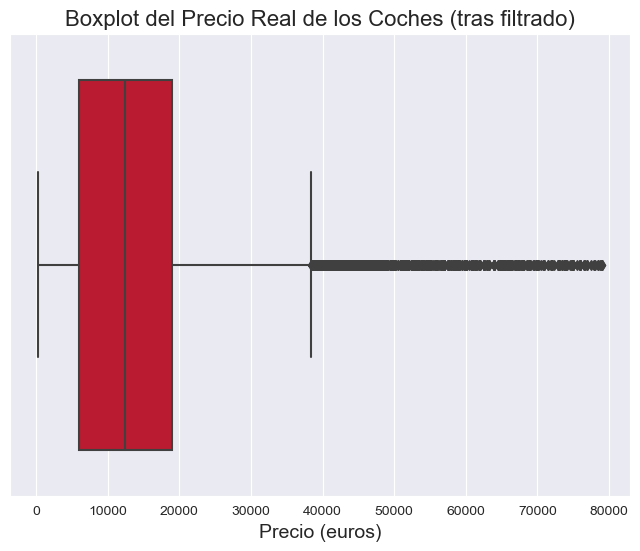

In [67]:
plt.figure(figsize=(8, 6))

# Boxplot con la transformación inversa de log(precio)
sns.boxplot(x=inv_boxcox(df["precio"], lambda_opt), color=colors[0])

plt.title("Boxplot del Precio Real de los Coches (tras filtrado)", fontsize=16)
plt.xlabel("Precio (euros)", fontsize=14)

plt.show()


Vemos que sólo hemos perdido 183 vehículos pero ahora el precio máximo es de 79.000 euros, lo que comprende más vehículos y elimina outliers que el modelo podría predecir mal.

In [68]:
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
0,AUDI,a3,57.722280,Híbrido,2023.0,46273,110.0,5.0,Automático,negro,WebScraping
1,HYUNDAI,i30,49.217755,Híbrido,2022.0,103209,120.0,5.0,Manual,None,WebScraping
2,TOYOTA,c-hr,53.897016,Híbrido,2020.0,110745,122.0,5.0,Automático,blanco,WebScraping
3,NISSAN,juke,52.136432,Gasolina,2022.0,63000,114.0,5.0,Automático,None,WebScraping
4,NISSAN,qashqai,57.102307,Híbrido,2022.0,62765,140.0,5.0,Manual,negro,WebScraping


Vemos que el precio ya no está en euros. Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47870 entries, 0 to 48052
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           47870 non-null  object 
 1   modelo          47870 non-null  object 
 2   precio          47870 non-null  float64
 3   combustible     47650 non-null  object 
 4   anyo_vehiculo   47868 non-null  float64
 5   kilometraje     47870 non-null  int64  
 6   potencia        40392 non-null  float64
 7   num_puertas     47755 non-null  float64
 8   tipo_cambio     47779 non-null  object 
 9   color           46507 non-null  object 
 10  origen_anuncio  47870 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 5.4+ MB


### Variables numéricas:

#### Potencia:

Vamos a analizar los nulos de la columna ```'potencia'```, a ver si son debidos al tipo de combustible o simplemente falta en esos registros.

In [70]:
df.groupby("combustible")["potencia"].apply(lambda x: x.isnull().sum())

combustible
Diesel                   3
Diésel                5238
Eléctrico                0
Gas licuado (GLP)        0
Gas natural (CNG)        0
Gasolina              2089
Híbrido                  0
Híbrido Enchufable       0
Híbrido enchufable       0
Name: potencia, dtype: int64

Como parece que hay varios formatos de la columna combustible, vamos a mapearlos:

In [71]:

mapa_combustible = {
    "Diesel": "Diésel",
    "Híbrido enchufable": "Híbrido Enchufable",
    "Híbrido Enchufable": "Híbrido Enchufable"
}

df["combustible"] = df["combustible"].replace(mapa_combustible)

In [72]:
df["combustible"].value_counts()

combustible
Diésel                28809
Gasolina              15814
Híbrido                1996
Híbrido Enchufable      469
Eléctrico               455
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

In [73]:
df[df["potencia"].isna()].groupby("combustible").size()

combustible
Diésel      5241
Gasolina    2089
dtype: int64

Observamos que todos los nulos son para vehículos de gasolina o diésel, por lo que vamos a eliminar estos registros del DataFrame, ya que tenemos una cantidad de datos abundante y puede ser un parámetro sensible en el modelo, por lo que tratar de rellenar esos NaN por alguna métrica como la media, puede afectar negativamente.

In [74]:
df = df.drop(index=(df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
0,AUDI,a3,57.722280,Híbrido,2023.0,46273,110.0,5.0,Automático,negro,WebScraping
1,HYUNDAI,i30,49.217755,Híbrido,2022.0,103209,120.0,5.0,Manual,None,WebScraping
2,TOYOTA,c-hr,53.897016,Híbrido,2020.0,110745,122.0,5.0,Automático,blanco,WebScraping
3,NISSAN,juke,52.136432,Gasolina,2022.0,63000,114.0,5.0,Automático,None,WebScraping
4,NISSAN,qashqai,57.102307,Híbrido,2022.0,62765,140.0,5.0,Manual,negro,WebScraping


c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


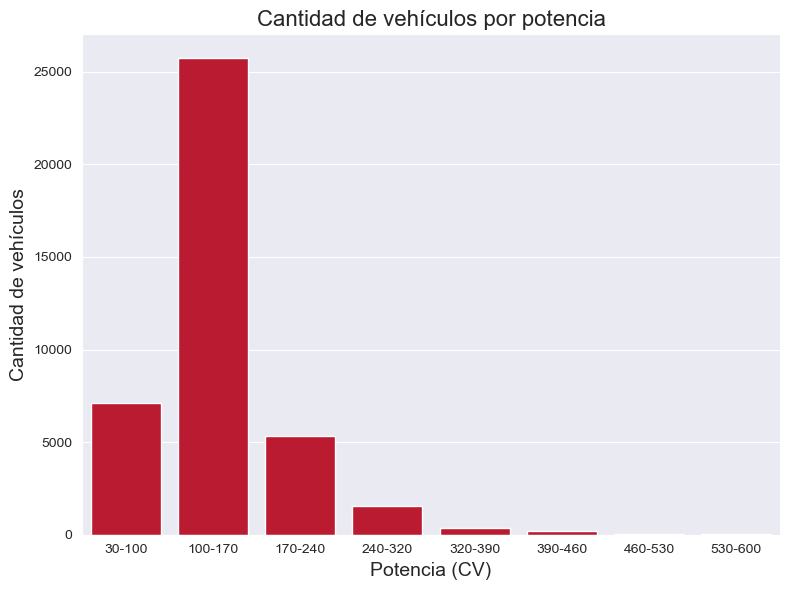

In [75]:
# Definimos los rangos de potencia:
min_potencia = df['potencia'].min()
max_potencia = df['potencia'].max()

num_bins = 8

bins = np.linspace(min_potencia, max_potencia, num_bins + 1) 
bins = np.round(bins, -1) 

labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

df_rangos = df.copy() 
df_rangos['potencia_rango'] = pd.cut(df_rangos['potencia'], bins=bins, labels=labels, right=False)

plt.figure(figsize = (8, 6))

sns.countplot(x=df_rangos["potencia_rango"], order=labels, color=colors[0])

plt.title("Cantidad de vehículos por potencia", fontsize=16)
plt.xlabel("Potencia (CV)", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
# plt.xticks(rotation=45)  

plt.xticks(ha='center') 
plt.tight_layout()

plt.show()

In [76]:
# Num de vehículos con potncia > 330 CV:

df.loc[df.loc[:, "potencia"] > 320, :].count()

marca             622
modelo            622
precio            622
combustible       622
anyo_vehiculo     622
kilometraje       622
potencia          622
num_puertas       622
tipo_cambio       622
color             606
origen_anuncio    622
dtype: int64

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40392 entries, 0 to 48052
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40392 non-null  object 
 1   modelo          40392 non-null  object 
 2   precio          40392 non-null  float64
 3   combustible     40320 non-null  object 
 4   anyo_vehiculo   40390 non-null  float64
 5   kilometraje     40392 non-null  int64  
 6   potencia        40392 non-null  float64
 7   num_puertas     40392 non-null  float64
 8   tipo_cambio     40301 non-null  object 
 9   color           39342 non-null  object 
 10  origen_anuncio  40392 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 3.7+ MB


#### Año:

In [90]:
# Vemos si hay alguno nulo:

df[df["anyo_vehiculo"].isna()]

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
36986,SEAT,arona,55.744723,Gasolina,NaN,1,115.0,5.0,Manual,negro,dataset kaggle
45970,KIA,stonic,51.122602,Gasolina,NaN,1,100.0,5.0,Manual,rojo,dataset kaggle


Vamos a ver la distribución de valores del campo ```"anyo_vehiculo"```.

Hay dos con valor nulo. Lo eliminamos y convertimos el resto a int:

In [91]:
df = df.dropna(subset=["anyo_vehiculo"])

df["anyo_vehiculo"] = df["anyo_vehiculo"].astype(int)

In [92]:
df["anyo_vehiculo"].value_counts()

anyo_vehiculo
2016    4634
2019    4536
2020    4143
2017    3939
2018    3589
2015    2690
2014    1705
2021    1296
2013    1245
2011    1128
2007    1123
2008    1099
2010    1081
2012    1053
2009     988
2006     948
2005     855
2004     679
2022     656
2024     480
2003     476
2023     458
2002     351
2001     281
2000     239
1999     182
1998     105
1997      72
1996      58
2025      44
1993      42
1995      35
1992      34
1994      30
1991      26
1989      25
1990      17
1988      11
1987      10
1986       8
1982       7
1985       5
1984       3
1983       3
1980       1
Name: count, dtype: int64

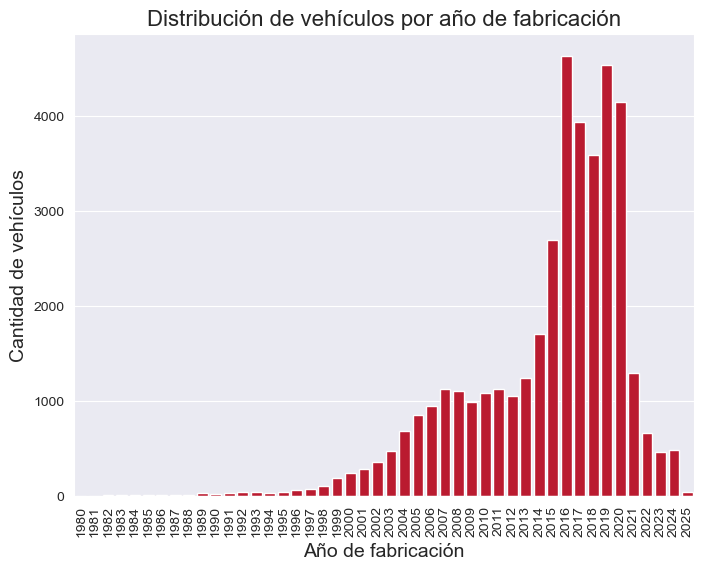

In [93]:
plt.figure(figsize = (8, 6))

rango_años = np.linspace(df["anyo_vehiculo"].min(), df["anyo_vehiculo"].max(), num=int(df["anyo_vehiculo"].max() - df["anyo_vehiculo"].min()) + 1, dtype=int)


sns.countplot(x=df["anyo_vehiculo"], order=rango_años, color=colors[0])

plt.title("Distribución de vehículos por año de fabricación", fontsize=16)
plt.xlabel("Año de fabricación", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
plt.xticks(rotation=90)  

plt.show()

#### Número de puertas:

Veamos los valores de la siguiente columna no numérica, ```"num_puertas"```:

In [94]:
df["num_puertas"] = df["num_puertas"].astype(int)

df["num_puertas"].value_counts()

num_puertas
5    30672
4     5660
3     2470
2     1588
Name: count, dtype: int64

Vamos a agrupar los coches de 5 puertas con los de 4, y los de 3 con los de 2, ya que la diferencia es que no se cuenta el maletero.

In [95]:
num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
                     
df["num_puertas"] = df["num_puertas"].map(num_puertas)

In [96]:
df["num_puertas"].value_counts()

num_puertas
5    36332
3     4058
Name: count, dtype: int64

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40390 entries, 0 to 48052
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40390 non-null  object 
 1   modelo          40390 non-null  object 
 2   precio          40390 non-null  float64
 3   combustible     40318 non-null  object 
 4   anyo_vehiculo   40390 non-null  int32  
 5   kilometraje     40390 non-null  int64  
 6   potencia        40390 non-null  float64
 7   num_puertas     40390 non-null  int64  
 8   tipo_cambio     40299 non-null  object 
 9   color           39340 non-null  object 
 10  origen_anuncio  40390 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(6)
memory usage: 3.5+ MB


### Variables categóricas:

#### Color:

La columna ```"color"``` sigue teniendo bastantes NaN.

In [103]:
# pd.set_option("display.max_rows", None)
df["color"] = df["color"].fillna('').str.lower()

df["color"].value_counts()

color
blanco          11268
gris             9786
negro            7132
azul             4930
rojo             2927
                 1050
verde             643
marrón            638
beige             604
granate           389
amarillo          317
gris / plata      317
naranja           253
plata              83
violeta            53
Name: count, dtype: int64

Vamos a eliminar la columna color, ya que es una columna categórica con 15 (uno de ellos con 1.050 nulos) valores únicos pero no aporta información valiosa al modelo.

In [49]:
df = df.drop(columns="color")

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40390 entries, 0 to 48052
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40390 non-null  object 
 1   modelo          40390 non-null  object 
 2   precio          40390 non-null  float64
 3   combustible     40318 non-null  object 
 4   anyo_vehiculo   40390 non-null  int32  
 5   kilometraje     40390 non-null  int64  
 6   potencia        40390 non-null  float64
 7   num_puertas     40390 non-null  int64  
 8   tipo_cambio     40299 non-null  object 
 9   origen_anuncio  40390 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 3.2+ MB


#### Tipo de cambio:

La columna ```"tipo_cambio"``` también continúa teniendo bastantes NaN.

In [182]:
df["tipo_cambio"].value_counts(dropna=False)

tipo_cambio
Manual        27524
Automático    12775
None             91
Name: count, dtype: int64

Como en la columna ```"tipo_cambio"``` existen muchos coches manuales y automáticos, vamos a eliminar las filas con valores de ```"tipo_cambio"``` nulos (91).

In [183]:
df = df.drop(index=(df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,AUDI,a3,57.722264,Híbrido,2023,46273,110.0,5,Automático,WebScraping
1,HYUNDAI,i30,49.217742,Híbrido,2022,103209,120.0,5,Manual,WebScraping
2,TOYOTA,c-hr,53.897002,Híbrido,2020,110745,122.0,5,Automático,WebScraping
3,NISSAN,juke,52.136418,Gasolina,2022,63000,114.0,5,Automático,WebScraping
4,NISSAN,qashqai,57.102291,Híbrido,2022,62765,140.0,5,Manual,WebScraping


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40299 entries, 0 to 48052
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40299 non-null  object 
 1   modelo          40299 non-null  object 
 2   precio          40299 non-null  float64
 3   combustible     40227 non-null  object 
 4   anyo_vehiculo   40299 non-null  int32  
 5   kilometraje     40299 non-null  int64  
 6   potencia        40299 non-null  float64
 7   num_puertas     40299 non-null  int64  
 8   tipo_cambio     40299 non-null  object 
 9   origen_anuncio  40299 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 3.2+ MB


Ahora que ya no contiene nulos, convertimos a numéricos los valores de la columna ```"tipo_cambio"```, mapeando como 0 los vehículos con cambio "Manual" y 1 los que tienen "Automático":

In [185]:
df["tipo_cambio"].value_counts()

tipo_cambio
Manual        27524
Automático    12775
Name: count, dtype: int64

In [186]:
df["tipo_cambio"] = df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

In [187]:
df["tipo_cambio"].value_counts()

tipo_cambio
0    27524
1    12775
Name: count, dtype: int64

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40299 entries, 0 to 48052
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40299 non-null  object 
 1   modelo          40299 non-null  object 
 2   precio          40299 non-null  float64
 3   combustible     40227 non-null  object 
 4   anyo_vehiculo   40299 non-null  int32  
 5   kilometraje     40299 non-null  int64  
 6   potencia        40299 non-null  float64
 7   num_puertas     40299 non-null  int64  
 8   tipo_cambio     40299 non-null  int64  
 9   origen_anuncio  40299 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 3.2+ MB


#### Combustible:

In [189]:
df[df["combustible"].isna()].count()

marca             72
modelo            72
precio            72
combustible        0
anyo_vehiculo     72
kilometraje       72
potencia          72
num_puertas       72
tipo_cambio       72
origen_anuncio    72
dtype: int64

Todavía hay 34 registros con el valor de combustible nulo, de modo que eliminamos estos registros:

In [190]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40227 entries, 0 to 48052
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40227 non-null  object 
 1   modelo          40227 non-null  object 
 2   precio          40227 non-null  float64
 3   combustible     40227 non-null  object 
 4   anyo_vehiculo   40227 non-null  int32  
 5   kilometraje     40227 non-null  int64  
 6   potencia        40227 non-null  float64
 7   num_puertas     40227 non-null  int64  
 8   tipo_cambio     40227 non-null  int64  
 9   origen_anuncio  40227 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 3.2+ MB


Vemos que nos hemos quedado con 40.069 filas de 14 marcas de vehículos. Ya no tenemos valores nulos, ahora vamos a procesar las columnas restantes para que puedan ser usadas en el modelo.

In [191]:
df["combustible"].value_counts()

combustible
Diésel                23503
Gasolina              13703
Híbrido                1994
Híbrido Enchufable      467
Eléctrico               453
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

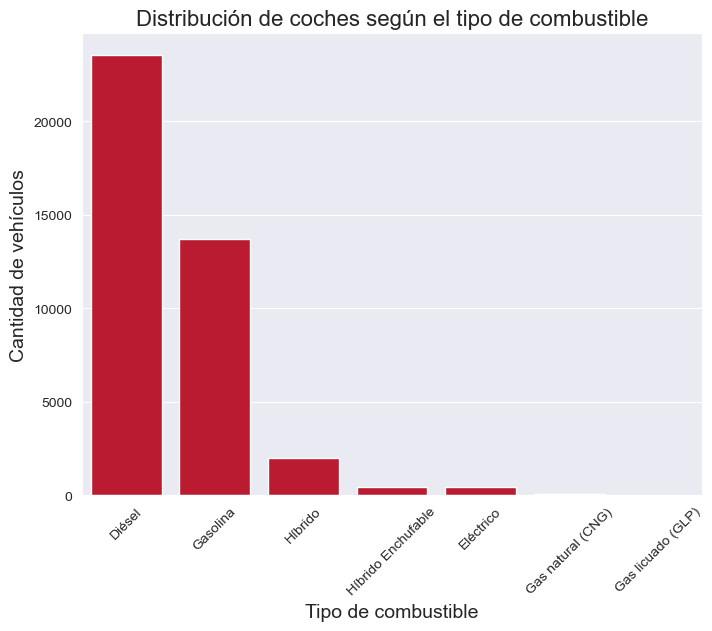

In [192]:
plt.figure(figsize = (8, 6))

sns.countplot(x=df["combustible"], order=df["combustible"].value_counts(ascending=False).index, color=colors[0])

plt.title("Distribución de coches según el tipo de combustible", fontsize=16)
plt.xlabel("Tipo de combustible", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
plt.xticks(rotation=45)  

plt.show()

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40227 entries, 0 to 48052
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40227 non-null  object 
 1   modelo          40227 non-null  object 
 2   precio          40227 non-null  float64
 3   combustible     40227 non-null  object 
 4   anyo_vehiculo   40227 non-null  int32  
 5   kilometraje     40227 non-null  int64  
 6   potencia        40227 non-null  float64
 7   num_puertas     40227 non-null  int64  
 8   tipo_cambio     40227 non-null  int64  
 9   origen_anuncio  40227 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 3.2+ MB


Vamos ahora a convertir la columna ```"combustible"``` en numérica a través de un mapeado:

In [194]:
df["combustible"].value_counts()

combustible
Diésel                23503
Gasolina              13703
Híbrido                1994
Híbrido Enchufable      467
Eléctrico               453
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

Vemos cómo predominan los coches de diésel y gasolina.

Convertimos los valores en numéricos utilizando un mapeado:

In [195]:
# Aplicamos un mapeado para la columna "combustible":

tipos_combutible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido Enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
df["combustible"] = df["combustible"].map(tipos_combutible)

In [196]:
df["combustible"].value_counts()

combustible
0    23503
1    13703
2     1994
4      467
3      453
6       58
5       49
Name: count, dtype: int64

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40227 entries, 0 to 48052
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40227 non-null  object 
 1   modelo          40227 non-null  object 
 2   precio          40227 non-null  float64
 3   combustible     40227 non-null  int64  
 4   anyo_vehiculo   40227 non-null  int32  
 5   kilometraje     40227 non-null  int64  
 6   potencia        40227 non-null  float64
 7   num_puertas     40227 non-null  int64  
 8   tipo_cambio     40227 non-null  int64  
 9   origen_anuncio  40227 non-null  object 
dtypes: float64(2), int32(1), int64(4), object(3)
memory usage: 3.2+ MB


#### Marca:

Antes de convertir las columnas ```"marca"``` y ```"modelo"``` en númericas, vamos a guardar en un set las marcas y modelos de coches que quedan en el DataFrame, para luego utilizarlas en la Web App de predicción de precios:

In [198]:
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,AUDI,a3,57.722264,2,2023,46273,110.0,5,1,WebScraping
1,HYUNDAI,i30,49.217742,2,2022,103209,120.0,5,0,WebScraping
2,TOYOTA,c-hr,53.897002,2,2020,110745,122.0,5,1,WebScraping
3,NISSAN,juke,52.136418,1,2022,63000,114.0,5,1,WebScraping
4,NISSAN,qashqai,57.102291,2,2022,62765,140.0,5,0,WebScraping


In [199]:
marca_modelo_set = {}

for index, row in df.iterrows():
    make = row['marca']
    model = row['modelo']
    
    if make not in marca_modelo_set:
        marca_modelo_set[make] = {model}
    else:
        marca_modelo_set[make].add(model)

# Guardamos el set con marcas y modelos en un pkl:

with open('../include/utils/marca_modelo_set.pkl', 'wb') as archivo_salida3:
    pickle.dump(marca_modelo_set, archivo_salida3)

print(marca_modelo_set)

{'AUDI': {'q3', 'rs4', 'a1', 'sq7', 'sq5', 'r8', 'q3 sportback', 's7', 'rs7', 'a3', 'coupe', 'rs5', 'rs q3', 'q2', 'q7', 'a6 allroad quattro', 'tt rs', 'a4', 'cabriolet', 's6', 'q5', 'a8', 's3', 'tts', 'allroad quattro', 'a6', 'a5', 'q8', 's4', 'rs3', 's5', 'rs6', 'a4 allroad quattro', 'tt', 'a7', 'a2', 's8', '90', '100', 'e-tron'}, 'HYUNDAI': {'lantra', 'i20', 'accent', 'matrix', 'kona', 'coupe', 'elantra', 'xg', 'i40', 'h-1 travel', 'Bayon 1.0 TGDI Maxx', 'atos', 'grand santa fe', 'terracan', 'i30', 'veloster', 'sonata', 'Bayon 1.2 MPI Maxx', 'h-1', 'atos prime', 'ix20', 'trajet', 'genesis', 'ioniq', 'i20 active', 'ix35', 'tucson', 'getz', 'i10', 'ix55', 'h350', 'santa fe'}, 'TOYOTA': {'corolla', 'prius+', 'proace', 'supra', 'dyna', 'c-hr', 'previa', 'rav4', 'land cruiser 200', 'urban cruiser', 'iq', 'avensis', 'Priusplus Advance', 'corolla sedan', 'avensis verso', 'land cruiser 80', 'land cruiser 90', 'yaris', 'land cruiser 100', 'gr yaris', 'gt86', 'hilux', 'prius', 'celica', '4run

Una vez guardado este set, empezamos con el análisis y procesado de las variables que utilizaremos en el modelo:

In [200]:
marca_df = df["marca"]
marca_df.value_counts()

marca
VOLKSWAGEN       4315
BMW              4027
MERCEDES-BENZ    3881
AUDI             3364
PEUGEOT          3109
FORD             2948
RENAULT          2948
OPEL             2869
CITROEN          2838
SEAT             2520
TOYOTA           2198
NISSAN           2116
HYUNDAI          1584
KIA              1510
Name: count, dtype: int64

Tenemos 14 marcas diferentes de coches. Vamos a hacer un countplot para ver cuántos vehículos tenemos de cada marca:

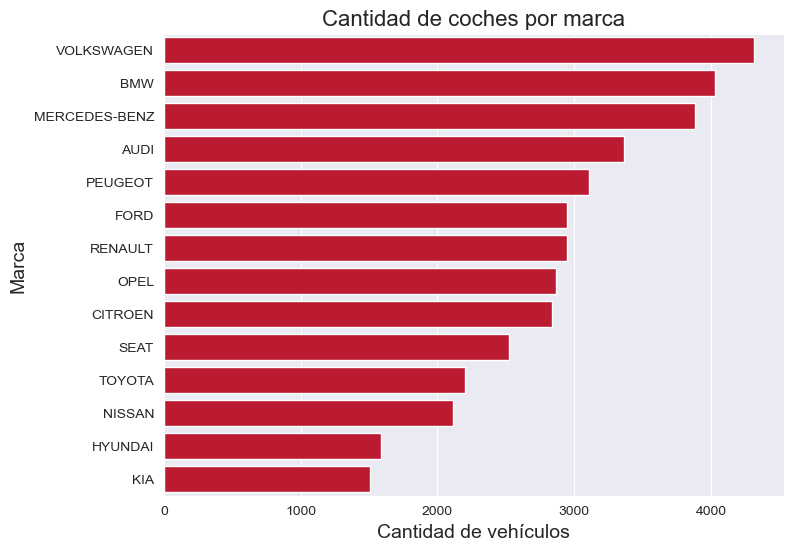

In [201]:
plt.figure(figsize = (8, 6))
sns.countplot(y = marca_df, order=marca_df.value_counts(ascending=False).index, color=colors[0])

plt.title("Cantidad de coches por marca", fontsize=16)
plt.xlabel("Cantidad de vehículos", fontsize=14)
plt.ylabel("Marca", fontsize=14)

plt.show()

En el gráfico vemos cómo tenemos muchos coches registrados en la base de datos para cada una de las 14 marcas.

Vamos a asignar un valor numérico a cada marca para poder utilizar dicha columna como feature del modelo:

In [202]:
# Asignamos cada marca a un valor numérico utilizando LabelEncoder:

from sklearn.preprocessing import LabelEncoder

encoder_marca = LabelEncoder()
encoder_marca.fit(df["marca"].sort_values(ascending=False))
list(encoder_marca.classes_)
df["marca"] = encoder_marca.transform(df["marca"])

# Guardamos el LabelEncoder para poder utilizarlo después en otros archivos:

with open('../include/utils/label_encoder_marca.pkl', 'wb') as archivo_salida1:
    pickle.dump(encoder_marca, archivo_salida1)

df["marca"].value_counts()

marca
13    4315
1     4027
6     3881
0     3364
9     3109
3     2948
10    2948
8     2869
2     2838
11    2520
12    2198
7     2116
4     1584
5     1510
Name: count, dtype: int64

In [203]:
# muestra las marcas originales

print(encoder_marca.classes_)


['AUDI' 'BMW' 'CITROEN' 'FORD' 'HYUNDAI' 'KIA' 'MERCEDES-BENZ' 'NISSAN'
 'OPEL' 'PEUGEOT' 'RENAULT' 'SEAT' 'TOYOTA' 'VOLKSWAGEN']


In [204]:
# Para visualizar el mapping de marca con LabelEncoder

list(encoder_marca.inverse_transform([0]))

['AUDI']

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40227 entries, 0 to 48052
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40227 non-null  int32  
 1   modelo          40227 non-null  object 
 2   precio          40227 non-null  float64
 3   combustible     40227 non-null  int64  
 4   anyo_vehiculo   40227 non-null  int32  
 5   kilometraje     40227 non-null  int64  
 6   potencia        40227 non-null  float64
 7   num_puertas     40227 non-null  int64  
 8   tipo_cambio     40227 non-null  int64  
 9   origen_anuncio  40227 non-null  object 
dtypes: float64(2), int32(2), int64(4), object(2)
memory usage: 3.1+ MB


#### Modelo:

Vamos ahora con la columna ```"modelo"```:

In [206]:
df["modelo"].value_counts()

modelo
golf              1433
serie 3           1038
qashqai           1032
ibiza              872
a3                 851
                  ... 
safrane              1
Opirus 3.8 V6        1
partner origin       1
wind                 1
pick-up              1
Name: count, Length: 513, dtype: int64

Tenemos 513 modelos diferentes. En esta ocasión no realizamos el countplot ya que es información demasiado específica para visualizar.

Aunque son muchos valores diferentes, por el momento, realizamos otro Label Encoder. Más adelante veremos si es una columna que aporte información al modelo.

In [207]:
from sklearn.preprocessing import LabelEncoder

encoder_modelo = LabelEncoder()
encoder_modelo.fit(df["modelo"].sort_values(ascending=False))
list(encoder_modelo.classes_)
df["modelo"] = encoder_modelo.transform(df["modelo"])

# Guardamos el Encoding:

with open('../include/utils/label_encoder_modelo.pkl', 'wb') as archivo_salida2:
    pickle.dump(encoder_modelo, archivo_salida2)

df["modelo"].value_counts()

modelo
241    1433
425    1038
387    1032
274     872
67      851
       ... 
413       1
61        1
356       1
490       1
364       1
Name: count, Length: 513, dtype: int64

In [208]:
# Para visualizar el mapping de model con LabelEncoder

list(encoder_modelo.inverse_transform([196]))

['crafter']

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40227 entries, 0 to 48052
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40227 non-null  int32  
 1   modelo          40227 non-null  int32  
 2   precio          40227 non-null  float64
 3   combustible     40227 non-null  int64  
 4   anyo_vehiculo   40227 non-null  int32  
 5   kilometraje     40227 non-null  int64  
 6   potencia        40227 non-null  float64
 7   num_puertas     40227 non-null  int64  
 8   tipo_cambio     40227 non-null  int64  
 9   origen_anuncio  40227 non-null  object 
dtypes: float64(2), int32(3), int64(4), object(1)
memory usage: 2.9+ MB


#### Origen anuncio:

Tan solo falta la columna ```"origen_anuncio"```, que vamos a eliminar ya que sólo la hemos mantenido para diferenciar el origen del anuncio, pero no la queremos utilizar en el modelo predictivo.

In [210]:
df.drop(columns=["origen_anuncio"], inplace=True)

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40227 entries, 0 to 48052
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   marca          40227 non-null  int32  
 1   modelo         40227 non-null  int32  
 2   precio         40227 non-null  float64
 3   combustible    40227 non-null  int64  
 4   anyo_vehiculo  40227 non-null  int32  
 5   kilometraje    40227 non-null  int64  
 6   potencia       40227 non-null  float64
 7   num_puertas    40227 non-null  int64  
 8   tipo_cambio    40227 non-null  int64  
dtypes: float64(2), int32(3), int64(4)
memory usage: 2.6 MB


Ya tenemos nuestro DataFrame con todas las columnas de tipo numérico, listas para ser utilizadas por el modelo (después de escalar, dividir los conjuntos de train y test, etc.).

Guardamos el DataFrame.

In [212]:
# Guardamos el DataFrame transformado

df.to_csv("../include/data/processed/df_pre_modelo.csv")

## 3. Modelos predictivos.

In [213]:
df = pd.read_csv("../include/data/processed/df_pre_modelo.csv", index_col=0).reset_index(drop=True)
df

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,0,67,57.722264,2,2023,46273,110.0,5,1
1,4,269,49.217742,2,2022,103209,120.0,5,0
2,12,110,53.897002,2,2020,110745,122.0,5,1
3,7,287,52.136418,1,2022,63000,114.0,5,1
4,7,387,57.102291,2,2022,62765,140.0,5,0
...,...,...,...,...,...,...,...,...,...
40222,5,440,44.955125,0,2012,195000,136.0,5,0
40223,7,387,50.239324,0,2016,79983,110.0,5,0
40224,7,387,50.144160,0,2018,88644,130.0,5,0
40225,7,491,55.818553,0,2018,36463,130.0,5,0


Ya tenemos 9 columnas numéricas con las que poder predecir la columna target (```"precio"```).

Vamos ahora a dividir los datos de X (features) e y (target).

In [ ]:
# Dividimos los datos en características y objetivo:

X = df.drop("precio", axis=1)
y = df["precio"]

In [215]:
X

,marca,modelo,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,0,67,2,2023,46273,110.0,5,1
1,4,269,2,2022,103209,120.0,5,0
2,12,110,2,2020,110745,122.0,5,1
3,7,287,1,2022,63000,114.0,5,1
4,7,387,2,2022,62765,140.0,5,0
...,...,...,...,...,...,...,...,...
40222,5,440,0,2012,195000,136.0,5,0
40223,7,387,0,2016,79983,110.0,5,0
40224,7,387,0,2018,88644,130.0,5,0
40225,7,491,0,2018,36463,130.0,5,0


Vamos a realizar un heatmap de las features de nuestro modelo, para ver cómo de correlacionadas están entre ellas:

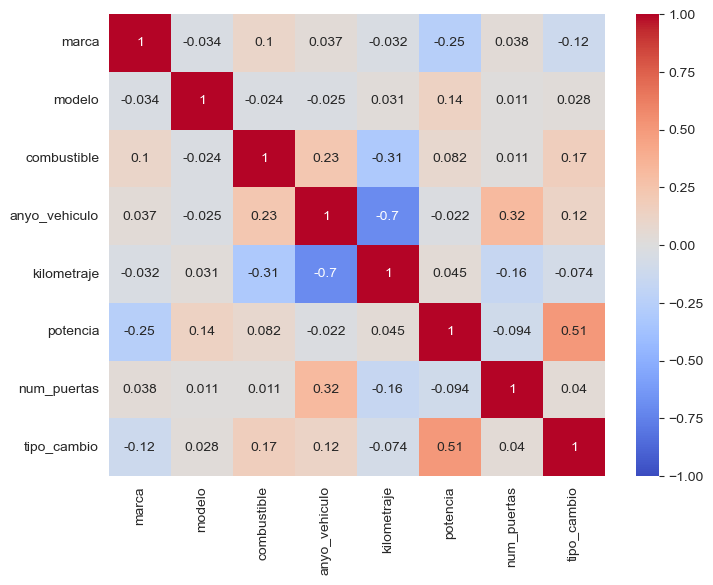

In [216]:
matriz_corr = X.corr(numeric_only=True).round(decimals=3)

plt.figure(figsize=(8, 6))

sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Vemos que la mayor correlación se da entre los kilómetros y el año del vehículo, y es negativa. Esto es lógico, ya que cuanto mayor sea el año (y más nuevo el coche), menor suele ser el número de kilómetros realizados.

Además de esto, cabe mencionar que ninguna de las correlaciones es lo suficientemente elevada como para plantearse prescindir de alguna columna.

Separamos los datos de train y test:

In [217]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32181, 8)
(8046, 8)
(32181,)
(8046,)


Vamos a escalar los datos de X entre 0 y 1:

In [218]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

# Guardamos el Scaler

with open('../include/utils/scaler.pkl', 'wb') as archivo_salida4:
    pickle.dump(scaler, archivo_salida4)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [219]:
X_train

array([[0.76923077, 0.57226562, 0.        , ..., 0.21006944, 1.        ,
        0.        ],
       [0.46153846, 0.31640625, 0.        , ..., 0.25694444, 1.        ,
        1.        ],
       [0.        , 0.1328125 , 0.        , ..., 0.21006944, 1.        ,
        1.        ],
       ...,
       [0.92307692, 0.59570312, 0.        , ..., 0.25      , 1.        ,
        0.        ],
       [0.38461538, 0.70898438, 0.16666667, ..., 0.06597222, 1.        ,
        0.        ],
       [0.76923077, 0.34570312, 0.        , ..., 0.07986111, 1.        ,
        0.        ]])

Comenzamos la seleción del modelo de regresión. Para ello, probamos varias parametrizaciones de modelos utilizando GridSearchCV.

In [220]:
# Importamos los modelos de regresión que utilizaremos

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost

from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import GridSearchCV

from sklearn import metrics

In [221]:
# LinearRegression??

### 3.1. Linear Regression.

In [222]:
# Linear Regression

param = {}

gs_lin_reg = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_lin_reg.fit(X_train, y_train)

y_pred = gs_lin_reg.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 16.835478889900607
RMSE: 4.103106005199062
MAE: 2.9534318640475536
MAPE: 0.06666862748950017
r2 score: 0.8409044013207096


### 3.2. Polynomial Regression.

In [223]:
# Polynomial Regression

param = {}

for degree in range(1, 6):

    poly_feat = PolynomialFeatures(degree = degree)

    poly_feat.fit(X_train)

    X_train_poly = poly_feat.transform(X_train)
    X_test_poly = poly_feat.transform(X_test)


    gs_poly = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

    gs_poly.fit(X_train_poly, y_train)

    y_pred = gs_poly.predict(X_test_poly)

    print(f"Poly Degree {degree}:")

    print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
    print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

    print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")
    print(" ")

Poly Degree 1:
MSE: 16.835478889901047
RMSE: 4.103106005199116
MAE: 2.953431864047785
MAPE: 0.06666862748951072
r2 score: 0.8409044013207054
 
Poly Degree 2:
MSE: 13.143025691884015
RMSE: 3.625331114792691
MAE: 2.6296103984590267
MAPE: 0.05974125413677833
r2 score: 0.8757981549213937
 
Poly Degree 3:
MSE: 11.224704429028627
RMSE: 3.3503290031023263
MAE: 2.4031120136483706
MAPE: 0.05496467287739735
r2 score: 0.8939263276790023
 
Poly Degree 4:
MSE: 9.851949548977116
RMSE: 3.1387815389059996
MAE: 2.2172731140643096
MAPE: 0.050919698355706804
r2 score: 0.9068988876465556
 
Poly Degree 5:
MSE: 964.533170741411
RMSE: 31.056934342291594
MAE: 2.4920828974089884
MAPE: 0.05419073187560596
r2 score: -8.114856978448861
 


In [ ]:
# El mejor es el de grado 4:

degree = 4
poly_feat = PolynomialFeatures(degree = degree)

poly_feat.fit(X_train)

X_train_poly = poly_feat.transform(X_train)
X_test_poly = poly_feat.transform(X_test)


best_poly_model = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

best_poly_model.fit(X_train_poly, y_train)

y_pred = best_poly_model.predict(X_test_poly)

print(f"Poly Degree {degree}:")

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

Poly Degree 3:
MSE: 11.224704429028627
RMSE: 3.3503290031023263
MAE: 2.4031120136483706
MAPE: 0.05496467287739735
r2 score: 0.8939263276790023


### 3.3. RandomForest.

In [225]:
# RandomForest

param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

gs_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_rf.fit(X_train, y_train)

y_pred = gs_rf.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 7.076866264905802
RMSE: 2.6602380090709556
MAE: 1.7598279519947166
MAPE: 0.04112340404413567
r2 score: 0.9331234779508485


In [226]:
gs_rf.best_params_

{'max_depth': 33, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}

### 3.4. ADA Boost Regression.

In [227]:
# ADA

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_ada = GridSearchCV(estimator=AdaBoostRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_ada.fit(X_train, y_train)

y_pred = gs_ada.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 19.34521995867061
RMSE: 4.398320129170978
MAE: 3.338573671033764
MAPE: 0.0794531838431606
r2 score: 0.8171873000444582


In [228]:
gs_ada.best_score_

-18.81610325158956

In [229]:
gs_ada.best_params_

{'learning_rate': 0.9, 'n_estimators': 100, 'random_state': 42}

### 3.5. Gradient Boosting Regression.

In [230]:
# Gradient Boost

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_gb.fit(X_train, y_train)

y_pred = gs_gb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 6.205057893304405
RMSE: 2.4909953619596332
MAE: 1.7505124357249802
MAPE: 0.04069386228569651
r2 score: 0.9413620837975017


### 3.6. XGradient Boosting Regression.

In [231]:
# XG Boost

param = {}

gs_xgb = GridSearchCV(estimator=xgboost.XGBRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_xgb.fit(X_train, y_train)

y_pred = gs_xgb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 6.551444322788454
RMSE: 2.559578934666492
MAE: 1.7526109449831762
MAPE: 0.040673954484197486
r2 score: 0.9380887253897284


### 3.7. Voting.

In [232]:
# Voting

# param = {"estimators":[gs_lin_reg.best_estimator_, best_poly_model.best_estimator_, gs_rf.best_estimator_, gs_ada.best_estimator_, gs_gb.best_estimator_, gs_xgb.best_estimator_],
#          "n_jobs":[-1]}

gs_voting = VotingRegressor(estimators=[("lin_reg", gs_lin_reg.best_estimator_), ("rf", gs_rf.best_estimator_), ("ada", gs_ada.best_estimator_), ("gb", gs_gb.best_estimator_), ("xgb", gs_xgb.best_estimator_)],
                            n_jobs=-1,)

gs_voting.fit(X_train, y_train)

y_pred = gs_voting.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 7.524257935887033
RMSE: 2.7430380850230702
MAE: 1.9230704565364916
MAPE: 0.04493571438923961
r2 score: 0.9288956180720549


El Voting da peor. El modelo con mejores métricas es el Gradient Boosting Regressor, aunque el XGradient Boosting y el RandomForest también estaba cerca. 

## 4. Selección y análisis del mejor modelo.

### 4.1. Selección de modelo:

Vamos a comparar en una tabla el resultado obtenido para el MSE de test en cada modelo, ya que es la métrica que estamos utilizando, con el fin de elegir el mejor:

In [2]:
import pandas as pd

In [3]:
df_comp_modelos = pd.DataFrame({"Modelo":["Linear Regression", "Polynomial Regression (grado 4)", "RandomForest", "ADA Boost", "Gradient Boost", "XG Boost", "Voting"],
                                "MAE":[2.9534, 2.2172, 1.7598, 3.3385, 1.7505, 1.7526, 1.9230],
                                "RMSE":[4.1031, 3.1388, 2.6602, 4.3983, 2.4909, 2.5595, 2.7430],
                                "r2 score":[0.8409, 0.9069, 0.9331, 0.8171, 0.9413, 0.9380, 0.9288]})

df_comp_modelos = df_comp_modelos.sort_values("MAE", ascending=True).reset_index(drop=True)
df_comp_modelos

,Modelo,MAE,RMSE,r2 score
0,Gradient Boost,1.7505,2.4909,0.9413
1,XG Boost,1.7526,2.5595,0.9380
2,RandomForest,1.7598,2.6602,0.9331
3,Voting,1.9230,2.7430,0.9288
4,Polynomial Regression (grado 4),2.2172,3.1388,0.9069
5,Linear Regression,2.9534,4.1031,0.8409
6,ADA Boost,3.3385,4.3983,0.8171


Vemos que el mejor modelo es el Gradient Boost, aunque está muy cerca el XGBoost. Vamos a quedarnos con el XGBoost, ya que su tiempo de entrenamiento es mucho menor y los resultados muy similares, y también con el RandomForest, ya que su funcionamiento es distinto y sus resultados están bastante cerca, por lo que puede sernos útil para comparar.

Cabe destacar que el MAE representado en la tabla anterior no se corresponde con el error medio en la predicción del modelo sobre el precio del vehículo, ya que hemos aplicado una transformación logarítmica a este precio. Más adelante veremos el MAE y el MSE reales del mejor modelo, una vez aplicada la transformación inversa. 

Vamos a ver si podemos mejorar algo de estos dos modelos mirando la importancia de las columnas (features) y realizando alguna modificación. Comenzamos con el RandomForest:

In [233]:
gs_rf.best_estimator_.feature_importances_

array([0.02630114, 0.03585169, 0.00740106, 0.51809273, 0.08748047,
       0.31197589, 0.00288025, 0.01001676])

Realizamos un dataframe con la importancia de las cada columna en el modelo RandomForest:

In [234]:
df_feat_imp_rf = pd.DataFrame(gs_rf.best_estimator_.feature_importances_, index=X.columns)
df_feat_imp_rf = df_feat_imp_rf.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp_rf

,Feature Importance
anyo_vehiculo,0.518093
potencia,0.311976
kilometraje,0.087480
modelo,0.035852
marca,0.026301
tipo_cambio,0.010017
combustible,0.007401
num_puertas,0.002880


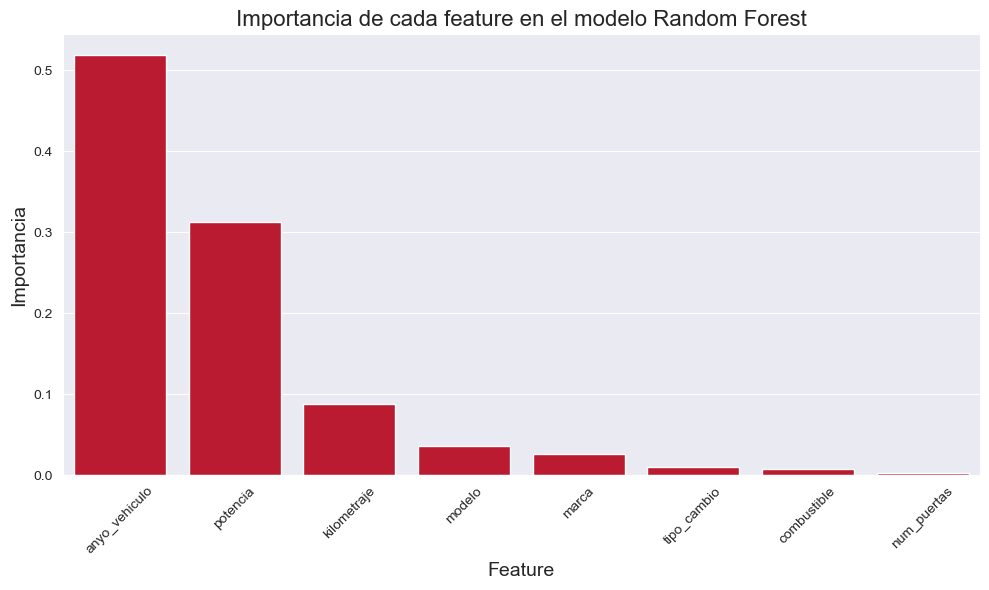

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6)) 


df_feat_imp_rf = df_feat_imp_rf.reset_index() 
df_feat_imp_rf.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp_rf, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo Random Forest", fontsize=16)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Importancia", fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se observa cómo las columnas con más importancia en el precio de un coche de segunda mano son, según nuestro modelo RandomForest, el año de matriculación, potencia del motor y kms recorridos. Las columnas de modelo y marca del coche también tienen algo de importancia, y las demás (tipo de cambio, combustible y número de puertas) tienen una importancia mucho menor.

Por esto, vamos a probar a hacer un Random Forest, con la misma parametrización que el mejor de antes, pero quitando las columnas menos importantes: ```["tipo_cambio", "combustible", "num_puertas"]```, a ver si mejora el modelo.

In [236]:
# RF 2

X_rf_2 = X.drop(columns=["tipo_cambio", "combustible", "num_puertas"])
X_rf_2

,marca,modelo,anyo_vehiculo,kilometraje,potencia
0,0,67,2023,46273,110.0
1,4,269,2022,103209,120.0
2,12,110,2020,110745,122.0
3,7,287,2022,63000,114.0
4,7,387,2022,62765,140.0
...,...,...,...,...,...
40222,5,440,2012,195000,136.0
40223,7,387,2016,79983,110.0
40224,7,387,2018,88644,130.0
40225,7,491,2018,36463,130.0


In [237]:
from sklearn.model_selection import train_test_split

X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2 = train_test_split(X_rf_2, y, test_size=0.2, random_state=42)

print(X_train_rf2.shape)
print(X_test_rf2.shape)
print(y_train_rf2.shape)
print(y_test_rf2.shape)

(32181, 5)
(8046, 5)
(32181,)
(8046,)


In [238]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_rf2)
X_train_rf2 = scaler.transform(X_train_rf2)
X_test_rf2 = scaler.transform(X_test_rf2)

In [239]:
# RandomForest

# param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

rf2 = RandomForestRegressor(n_estimators=300, max_depth=33, n_jobs=-1, random_state=42)

rf2.fit(X_train_rf2, y_train_rf2)

y_pred_rf2 = rf2.predict(X_test_rf2)

print(f"MSE: {metrics.mean_squared_error(y_test_rf2, y_pred_rf2)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_rf2, y_pred_rf2))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_rf2, y_pred_rf2)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_rf2, y_pred_rf2)}")

print(f"r2 score: {metrics.r2_score(y_test_rf2, y_pred_rf2)}")

MSE: 7.500970822728123
RMSE: 2.738790028959526
MAE: 1.8197592540377456
MAPE: 0.042441818650178674
r2 score: 0.9291156817384204


### 4.2. Análisis del modelo definitivo:

Obtenemos un MSE más elevado que antes, por lo que no mejora. Nos quedamos entonces el XG Boost, que es el modelo con el MSE más bajo y el más rápido de entrenar. Vamos a ver la importancia de las features en este modelo:

In [240]:
xgb_model = xgboost.XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 6.551444322788454
RMSE: 2.559578934666492
MAE: 1.7526109449831762
MAPE: 0.040673954484197486
r2 score: 0.9380887253897284


In [241]:
X.columns

Index(['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje',
       'potencia', 'num_puertas', 'tipo_cambio'],
      dtype='object')

In [242]:
xgb_model.feature_importances_

array([0.0413649 , 0.01846637, 0.02494314, 0.41880536, 0.04263186,
       0.25573853, 0.01920591, 0.17884396], dtype=float32)

In [243]:
df_feat_imp = pd.DataFrame(xgb_model.feature_importances_, index=X.columns)
df_feat_imp = df_feat_imp.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp

,Feature Importance
anyo_vehiculo,0.418805
potencia,0.255739
tipo_cambio,0.178844
kilometraje,0.042632
marca,0.041365
combustible,0.024943
num_puertas,0.019206
modelo,0.018466


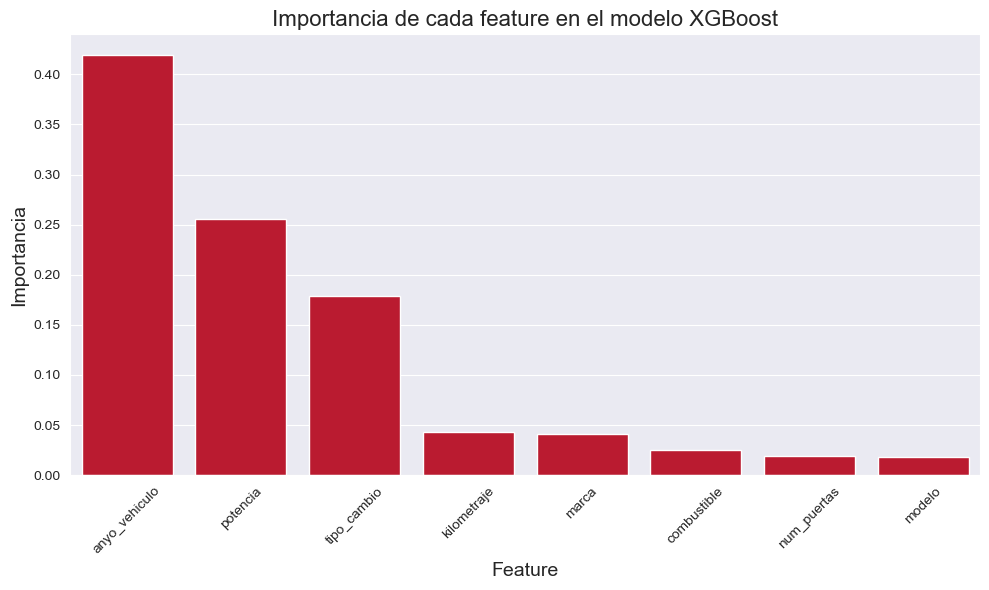

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

df_feat_imp = df_feat_imp.reset_index()
df_feat_imp.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo XGBoost", fontsize=16)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Importancia", fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


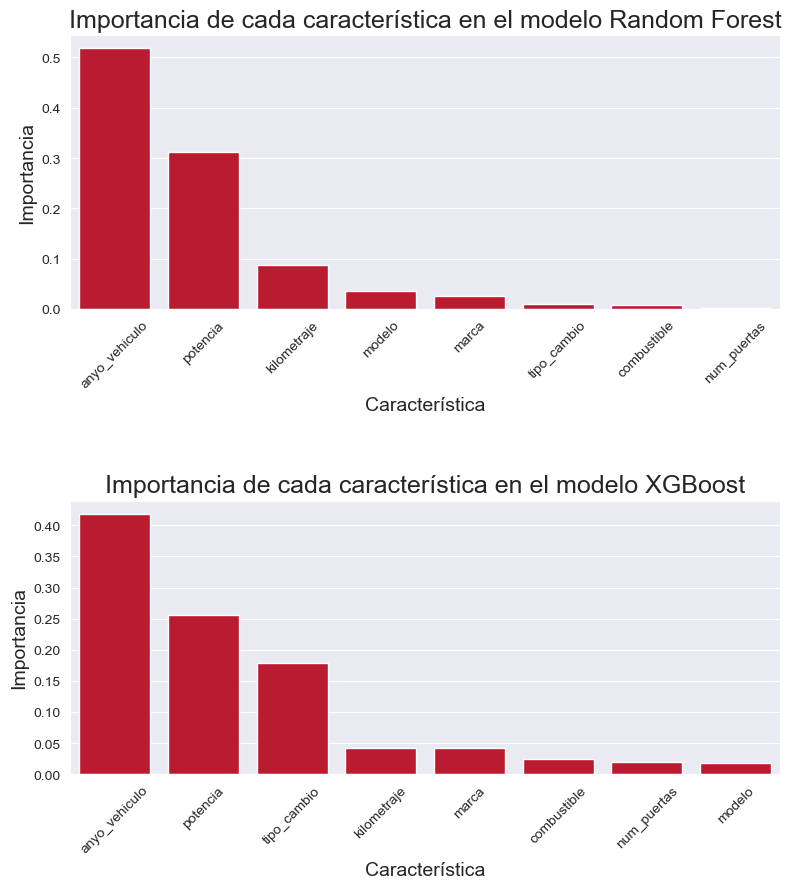

In [245]:
# Comparativa entre importancias del Randomforest y XG Boost:

import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que estos DataFrames ya tienen una columna 'Feature'
# Si no, usa reset_index() solo si el índice representa las features

# Crear la figura y los subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 9))

# Gráfico 1 - RandomForest
sns.barplot(data=df_feat_imp_rf, x='Feature', y='Feature Importance', color=colors[0], ax=axes[0])
axes[0].set_title("Importancia de cada característica en el modelo Random Forest", fontsize=18)
axes[0].set_xlabel("Característica", fontsize=14)
axes[0].set_ylabel("Importancia", fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2 - XGBoost
sns.barplot(data=df_feat_imp, x='Feature', y='Feature Importance', color=colors[0], ax=axes[1])
axes[1].set_title("Importancia de cada característica en el modelo XGBoost", fontsize=18)
axes[1].set_xlabel("Característica", fontsize=14)
axes[1].set_ylabel("Importancia", fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)  # aumenta el espacio vertical entre subplots
plt.show()


Ahora observamos que las columnas más importantes siguen siendo ```"anyo_vehiculo"``` y ```"potencia"```. Sin embargo, el XGBoost le da mucha más importancia a la columna ```"tipo_cambio"``` que el RandomForest previo, y menos a la columna ```"kilometraje"```. Además la importancia de las columnas menos importantes es más elevada que en el anterior modelo, por lo que no descartaremos ninguna de estas columnas.

Vamos a deshacer la transformación que realizamos en la columna ```"precio"``` (target) para ver la dimensión real de nuestras métricas:

In [246]:
inv_boxcox(df["precio"][0], lambda_opt)

25289.99999999999

In [ ]:
y_pred = xgb_model.predict(X_test)

# Deshacemos la transformación Box-Cox:

y_test_final = inv_boxcox(y_test, lambda_opt)
y_pred_final = inv_boxcox(y_pred, lambda_opt)

# Claculamos las métricas reales:
print(f"MSE: {metrics.mean_squared_error(y_test_final, y_pred_final)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_final, y_pred_final))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_final, y_pred_final)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_final, y_pred_final)}")

print(f"r2 score: {metrics.r2_score(y_test_final, y_pred_final)}")

MSE: 8181975.19443998
RMSE: 2860.415213642939
MAE: 1707.817019806553
MAPE: 0.1387254641084232
r2 score: 0.9276348038637756


Vemos que el MAE = 1.707 euros. Esto significa que para cada vehículo nos podemos ir esa cantidad de dinero de media en la predicción. 

El RMSE es algo mayor, 2.860 euros, lo cual se debe a que existen unos pocos coches cuyo error es alto, y al hacer el error cuadrático este error se hace más grande.

En cuanto al MAPE, nos indica que nuestro modelo tiene un % de error medio del 13.87% sobre el precio del vehículo, el cual es algo elevado.

Vamos a exportar el modelo final:

In [249]:
import pickle

# Guardamos el modelo final:

with open("../include/model/modelo_final.pkl", 'wb') as archivo_salida:
    pickle.dump(xgb_model, archivo_salida)


Creamos una función que nos permita meter nuevos inputs en el formato de nuestro DataFrame inicial y extraer las variables para pasar directamente al modelo.

Además, creamos otras dos funciones: una para realizar predicciones y otra para destransformar la columna target ```"precio"```.

In [273]:
lambda_opt

0.2805938549051249

In [292]:
# Función para transformar un df con nuevos inputs de la base de datos en X, y para pasar al modelo.

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pickle
from scipy.stats import boxcox
from scipy.special import inv_boxcox


def new_input_clean(input_df):
    '''
    Introduce los nuevos inputs en formato DataFrame con las columnas iniciales y devuelve los datos listos para introducirlos al modelo.

    El input DataFrame debe contener al menos las columnas (['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 
    'num_puertas', 'tipo_cambio'])
    '''

    excepciones = ['marca', 'modelo', 'precio', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 'num_puertas', 'tipo_cambio']

    # Reemplazar NaN con 0 excepto en las columnas de excepciones (las que utiliza el modelo)
    input_df = input_df.fillna({col: 0 for col in input_df.columns if col not in excepciones})


    input_df = input_df[excepciones]
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
    input_df = input_df.dropna()

    # Importamos los encodings hechos antes:
    encoder_marca = pickle.load(open("../include/utils/label_encoder_marca.pkl", 'rb'))
    encoder_modelo = pickle.load(open("../include/utils/label_encoder_modelo.pkl", 'rb'))

    list(encoder_marca.classes_)
    input_df["marca"] = encoder_marca.transform(input_df["marca"])

    list(encoder_modelo.classes_)
    input_df["modelo"] = encoder_modelo.transform(input_df["modelo"])

    tipos_combustible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
    input_df["combustible"] = input_df["combustible"].map(tipos_combustible)

    num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
    
    input_df["num_puertas"] = input_df["num_puertas"].map(num_puertas)
    
    input_df["tipo_cambio"] = input_df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

    # input_df["precio"] = np.log(input_df["precio"])

    # Valor de lambda utilizado en la transformación del modelo:
    lambda_box = 0.2805938549051249

    # Transformación Box-Cox del precio:
    input_df["precio"] = boxcox(x=input_df["precio"], lmbda=lambda_box)

    X_input = input_df.drop("precio", axis=1)
    y_input = input_df["precio"]
    

    scaler = pickle.load(open("../include/utils/scaler.pkl", 'rb'))

    X_input = scaler.transform(X_input)

    return [X_input, y_input]

# Función para hacer predicciones

def predict(loaded_model, X_input):
    return loaded_model.predict(X_input)

# Función para deshacer la transformación y devolver el precio:

import numpy as np

def destransformar_y(y_out):
    lambda_box = 0.2805938549051249
    # return np.exp(y_out)
    return inv_boxcox(y_out, lambda_box)

Vamos ahora a cargar el modelo y probarlo con un DataFrame de prueba con coches, para ver el precio que predice. 

In [287]:
import pickle

loaded_model = pickle.load(open("../include/model/modelo_final.pkl", 'rb'))

In [288]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [289]:
import pandas as pd
import sqlite3

# Conexión a la BBDD:
con = sqlite3.connect("../include/db_vehiculos.db")

# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO
where
    marca in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT', 'HYUNDAI', 'KIA', 'NISSAN', 'TOYOTA')
order by
    fecha_carga desc
;
"""

# Leemos los resultados en un DataFrame de pandas
df = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):
df_prueba = df.head()

df_prueba

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60611029,AUDI,a3,25290.0,Híbrido,2023.0,46273,110.0,5.0,5.0,...,Berlina,999.0,negro,Ciudad Real,ECO (azul/verde),WebScraping,2025-05-20,202505,2025-06-07 06:51:00,https://www.coches.net/audi-a3-sportback-30-tf...
1,60652943,HYUNDAI,i30,14850.0,Híbrido,2022.0,103209,120.0,5.0,5.0,...,Familiar,998.0,None,A Coruña,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:24:18,https://www.coches.net/hyundai-i30-10-tgdi-48v...
2,60716264,TOYOTA,c-hr,20100.0,Híbrido,2020.0,110745,122.0,5.0,5.0,...,Berlina,1798.0,blanco,Madrid,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:22:36,https://www.coches.net/toyota-c-hr-18-125h-act...
3,60206285,NISSAN,juke,17990.0,Gasolina,2022.0,63000,114.0,5.0,5.0,...,SUV,999.0,None,Las Palmas,None,WebScraping,2025-06-03,202506,2025-06-03 13:21:36,https://www.coches.net/nissan-juke-digt-84-kw-...
4,60716125,NISSAN,qashqai,24390.0,Híbrido,2022.0,62765,140.0,5.0,5.0,...,SUV,1332.0,negro,Huelva,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:20:26,https://www.coches.net/nissan-qashqai-digt-103...


In [290]:
X_input, y_input = new_input_clean(input_df=df_prueba)

In [268]:
predictions = loaded_model.predict(X_input)
predictions

array([57.638596, 49.949112, 53.284588, 52.034492, 55.65942 ],
      dtype=float32)

In [293]:
y_prueba = destransformar_y(predictions).round(0)
y_prueba

array([25167., 15596., 19347., 17873., 22385.], dtype=float32)

Insertamos las predicciones realizadas en la columna ```"precio_predicho"```, al lado de la columna target ```"precio"```:

In [294]:
df_prueba.insert(4, "precio_predicho", y_prueba)
df_prueba.to_csv("../include/data/processed/df_prueba_pred.csv")
df_prueba

,pk_anuncio_id,marca,modelo,precio,precio_predicho,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60611029,AUDI,a3,25290.0,25167.0,Híbrido,2023.0,46273,110.0,5.0,...,Berlina,999.0,negro,Ciudad Real,ECO (azul/verde),WebScraping,2025-05-20,202505,2025-06-07 06:51:00,https://www.coches.net/audi-a3-sportback-30-tf...
1,60652943,HYUNDAI,i30,14850.0,15596.0,Híbrido,2022.0,103209,120.0,5.0,...,Familiar,998.0,None,A Coruña,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:24:18,https://www.coches.net/hyundai-i30-10-tgdi-48v...
2,60716264,TOYOTA,c-hr,20100.0,19347.0,Híbrido,2020.0,110745,122.0,5.0,...,Berlina,1798.0,blanco,Madrid,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:22:36,https://www.coches.net/toyota-c-hr-18-125h-act...
3,60206285,NISSAN,juke,17990.0,17873.0,Gasolina,2022.0,63000,114.0,5.0,...,SUV,999.0,None,Las Palmas,None,WebScraping,2025-06-03,202506,2025-06-03 13:21:36,https://www.coches.net/nissan-juke-digt-84-kw-...
4,60716125,NISSAN,qashqai,24390.0,22385.0,Híbrido,2022.0,62765,140.0,5.0,...,SUV,1332.0,negro,Huelva,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:20:26,https://www.coches.net/nissan-qashqai-digt-103...


Vemos que los precios que predice el modelo se ajustan bastante a los reales.

## Idea: división en segmentos.

1. Segmento medio: hasta 30k eur.
2. Segmento premium: desde 30k eur.